In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from datasetcontroller.datacontroller import DataController
import os
import tensorflow as tf
from nnmodules.unet import Unet_v3, Unet_v4, Unet_v5
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
BATCH_SIZE = 8
train_set_len = 100
shuffle_buffer_size = 100

def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(8, 8))
  # display_list = [test_input[0][0][:,:,:3], tar[0][:,:,0][::-1], prediction[0][::-1]]
  # title = ['Input', 'Ground Truth', 'Predicted Image']
  print(prediction.shape, tar.shape)
  display_list = [tar[0][::-1], prediction[0][::-1]]
  title = ['Ground Truth', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

* 데이터셋

In [6]:
# 데이터셋 폴더 경로 설정
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# 모델 체크포인트
proj_path = os.path.join(path,'repos','cmaqProject')
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_4_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 컨트롤러
datacontroller = DataController(data_path = data_path)

# 기본 control matrix, smoke, cmaq 데이터셋 
control_matrix, smoke_arr, target_arr = datacontroller.get_yearly_dataset()

# 학습용셋
train_input = control_matrix[:train_set_len]
test_input = control_matrix[train_set_len:]

train_output = target_arr[:train_set_len]
test_output = target_arr[train_set_len:]

train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)


train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)


/usr/local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


## 모델 v1

In [4]:
# 1번 시나리오 베이스맵으로 사용
base_map = target_arr[0]
## 모델 체크포인트 생성
optimizer = tf.keras.optimizers.Adam(0.001)
unet = Unet_v3(base_map)
unet.compile()

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 unet=unet,
                                 )

# ####### 저장된 모델 있을 경우 ##########
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)

* 체크

1


2023-05-26 01:18:40.400245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


(1, 82, 67, 1) (1, 82, 67, 1)


2023-05-26 01:18:42.461970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


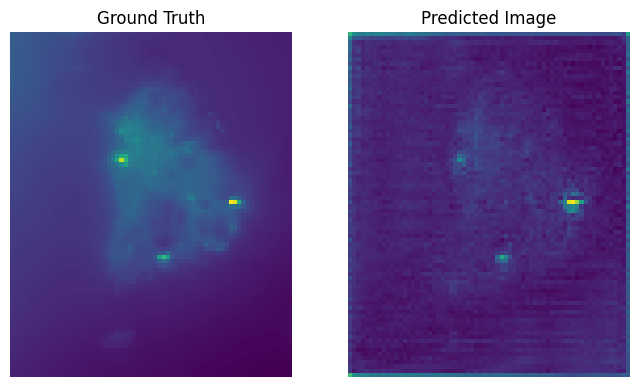

In [5]:
for batch in test_ds.take(1):
    print(1)
generate_images(unet, batch[0][0:1], batch[1][0:1])

* 학습

In [6]:
import datetime

init_lr = 0.001
steps = 3000

In [7]:
@tf.function
def train_step(input, target,optimizer):
    with tf.GradientTape() as tape:
        output = unet(input, training=True)
        l1_loss = unet.lose_mse(target, output)
    gradients = tape.gradient(l1_loss,
                                            unet.trainable_variables)

    optimizer.apply_gradients(zip(gradients,
                                            unet.trainable_variables))
start = time.time()

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():
  
  if (step) % 100 == 0:
    if step != 0:
      print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

    start = time.time()
    print(f"Step: {step}")

  train_step(input_arr, target,optimizer)

  if step % 1000 == 0:
    if step != 0:
      init_lr = init_lr*0.1
      optimizer = tf.keras.optimizers.Adam(init_lr)
      @tf.function
      def train_step(input_image, target,optimizer):
          with tf.GradientTape() as tape:
              output = unet(input_image, training=True)
              l1_loss = unet.lose_mse(target, output)
          gradients = tape.gradient(l1_loss,
                                                  unet.trainable_variables)

          optimizer.apply_gradients(zip(gradients,
                                                  unet.trainable_variables))

  # Training step
  if (step+1) % 10 == 0:
    print('.', end='', flush=True)


  # # Save (checkpoint) the model every 1k steps
  # if (step + 1) % 1000 == 0:
  #   checkpoint.save(file_prefix=checkpoint_prefix)

2023-05-26 01:18:42.722903: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


Step: 0


2023-05-26 01:18:50.464641: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0xa9500900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-26 01:18:50.464662: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-26 01:18:50.464665: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-26 01:18:50.464668: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-26 01:18:50.464672: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-26 01:18:50.468032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-0

..........Time taken for 100 steps: 26.06 sec

Step: 100
..........Time taken for 100 steps: 10.55 sec

Step: 200
..........Time taken for 100 steps: 10.60 sec

Step: 300
..........Time taken for 100 steps: 10.53 sec

Step: 400
..........Time taken for 100 steps: 10.54 sec

Step: 500
..........Time taken for 100 steps: 10.62 sec

Step: 600
..........Time taken for 100 steps: 10.54 sec

Step: 700
..........Time taken for 100 steps: 10.55 sec

Step: 800
..........Time taken for 100 steps: 10.55 sec

Step: 900
..........Time taken for 100 steps: 11.49 sec

Step: 1000
..........Time taken for 100 steps: 19.77 sec

Step: 1100
..........Time taken for 100 steps: 10.62 sec

Step: 1200
..........Time taken for 100 steps: 10.55 sec

Step: 1300
..........Time taken for 100 steps: 10.61 sec

Step: 1400
..........Time taken for 100 steps: 10.55 sec

Step: 1500
..........Time taken for 100 steps: 10.56 sec

Step: 1600
..........Time taken for 100 steps: 10.55 sec

Step: 1700
..........Time taken fo

* 평가

1/1 [==============================] - 4s 4s/step


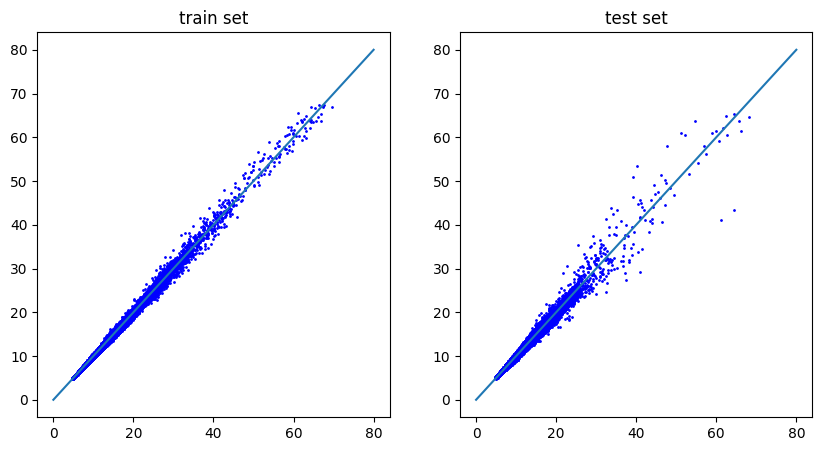

In [8]:
pred_train = unet.predict(train_input)
pred_test = unet.predict(test_input)

plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.title('train set')
plt.plot(pred_train.reshape(-1), train_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

plt.subplot(1,2,2)
plt.title('test set')
plt.plot(pred_test.reshape(-1), test_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

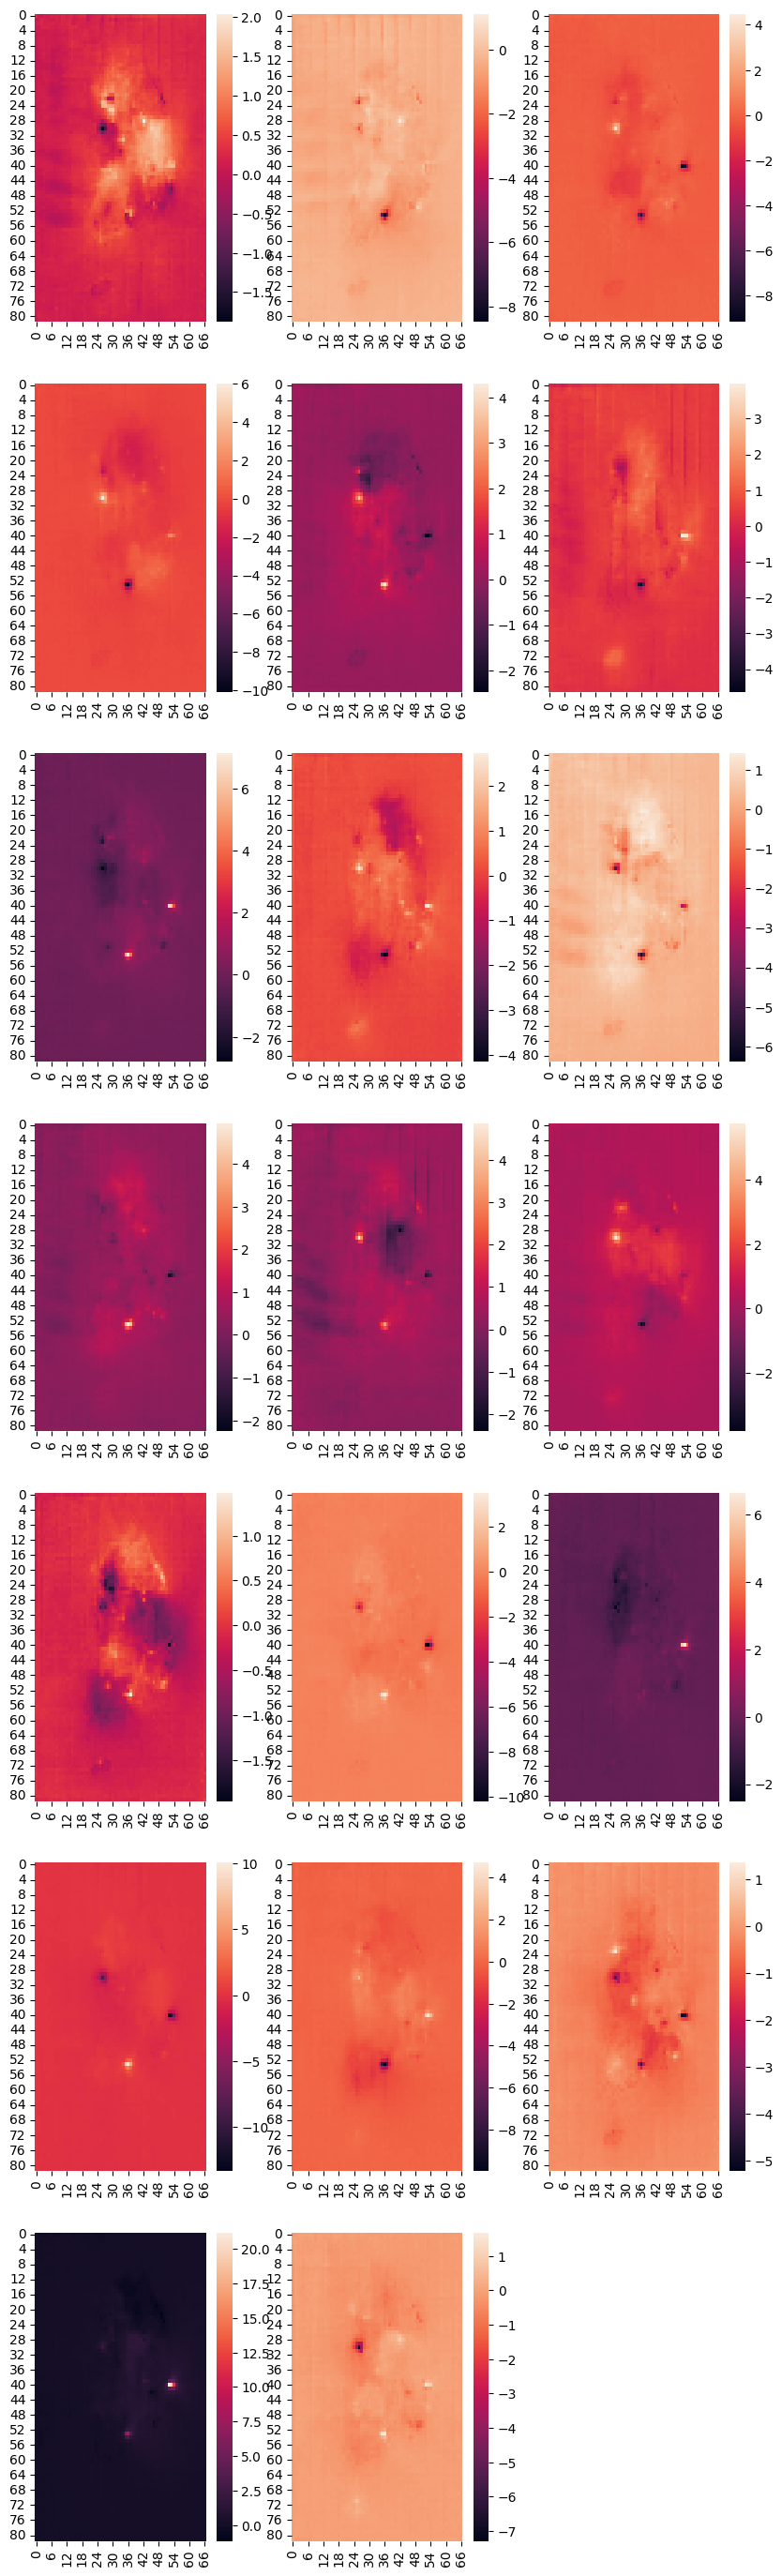

In [9]:
plt.figure(figsize = [10,35])
for i in range(len(pred_test)):
    plt.subplot(7,3,i+1)
    sns.heatmap(pred_test[i][:,:,0][::-1] - test_output[i][:,:,0][::-1])

## 모델 v2

In [4]:
# 1번 시나리오 베이스맵으로 사용
base_map = target_arr[0]
## 모델 체크포인트 생성
optimizer = tf.keras.optimizers.Adam(0.001)
unet = Unet_v4(base_map)
unet.compile()

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 unet=unet,
                                 )

# ####### 저장된 모델 있을 경우 ##########
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)

* 체크

1
(1, 82, 67, 1) (1, 82, 67, 1)


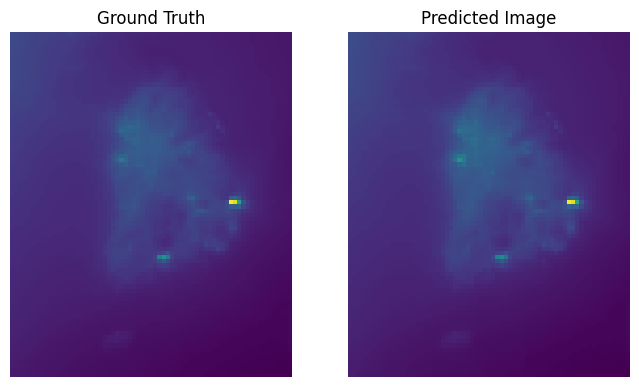

In [12]:
for batch in test_ds.take(1):
    print(1)
generate_images(unet, batch[0][0:1], batch[1][0:1])

* 학습

In [6]:
import datetime

init_lr = 0.001
steps = 2000

In [7]:
@tf.function
def train_step(input, target,optimizer):
    with tf.GradientTape() as tape:
        output = unet(input, training=True)
        l1_loss = unet.lose_mse(target, output)
    gradients = tape.gradient(l1_loss,
                                            unet.trainable_variables)

    optimizer.apply_gradients(zip(gradients,
                                            unet.trainable_variables))
start = time.time()

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():
  
  if (step) % 100 == 0:
    if step != 0:
      print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

    start = time.time()
    print(f"Step: {step}")

  train_step(input_arr, target,optimizer)

  if step % 1000 == 0:
    if step != 0:
      init_lr = init_lr*0.1
      optimizer = tf.keras.optimizers.Adam(init_lr)
      @tf.function
      def train_step(input_image, target,optimizer):
          with tf.GradientTape() as tape:
              output = unet(input_image, training=True)
              l1_loss = unet.lose_mse(target, output)
          gradients = tape.gradient(l1_loss,
                                                  unet.trainable_variables)

          optimizer.apply_gradients(zip(gradients,
                                                  unet.trainable_variables))

  # Training step
  if (step+1) % 10 == 0:
    print('.', end='', flush=True)


  # # Save (checkpoint) the model every 5k steps
  # if (step + 1) % 1000 == 0:
  #   checkpoint.save(file_prefix=checkpoint_prefix)

2023-05-25 06:55:45.919185: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


Step: 0


2023-05-25 06:55:54.343223: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x9d745780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-25 06:55:54.343272: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-25 06:55:54.343283: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-25 06:55:54.343293: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-25 06:55:54.343303: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-25 06:55:54.352298: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-0

..........Time taken for 100 steps: 29.93 sec

Step: 100
..........Time taken for 100 steps: 12.06 sec

Step: 200
..........Time taken for 100 steps: 11.95 sec

Step: 300
..........Time taken for 100 steps: 12.06 sec

Step: 400
..........Time taken for 100 steps: 12.01 sec

Step: 500
..........Time taken for 100 steps: 12.01 sec

Step: 600
..........Time taken for 100 steps: 12.06 sec

Step: 700
..........Time taken for 100 steps: 11.99 sec

Step: 800
..........Time taken for 100 steps: 12.02 sec

Step: 900
..........Time taken for 100 steps: 12.08 sec

Step: 1000
..........Time taken for 100 steps: 22.88 sec

Step: 1100
..........Time taken for 100 steps: 12.01 sec

Step: 1200
..........Time taken for 100 steps: 12.08 sec

Step: 1300
..........Time taken for 100 steps: 12.02 sec

Step: 1400
..........Time taken for 100 steps: 12.09 sec

Step: 1500
..........Time taken for 100 steps: 12.00 sec

Step: 1600
..........Time taken for 100 steps: 12.00 sec

Step: 1700
..........Time taken fo

* 평가

5/5 [==============================] - 0s 20ms/step


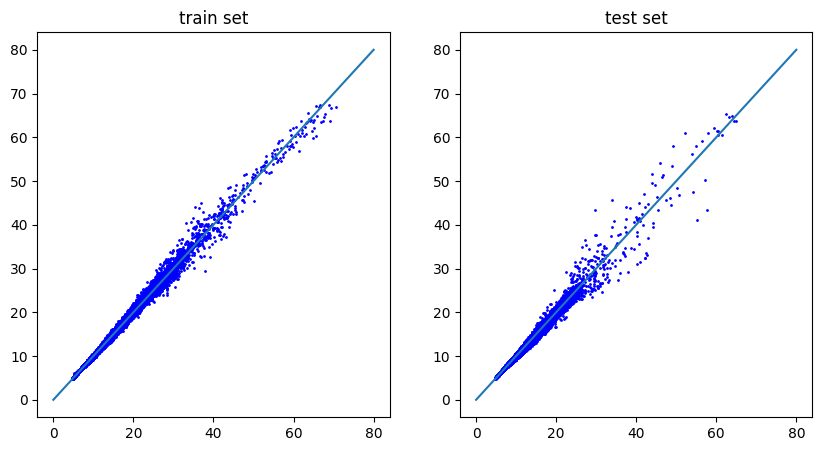

In [22]:
pred_train = unet.predict(train_input,batch_size = 4)
pred_test = unet.predict(test_input,batch_size = 4)

plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.title('train set')
plt.plot(pred_train.reshape(-1), train_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

plt.subplot(1,2,2)
plt.title('test set')
plt.plot(pred_test.reshape(-1), test_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

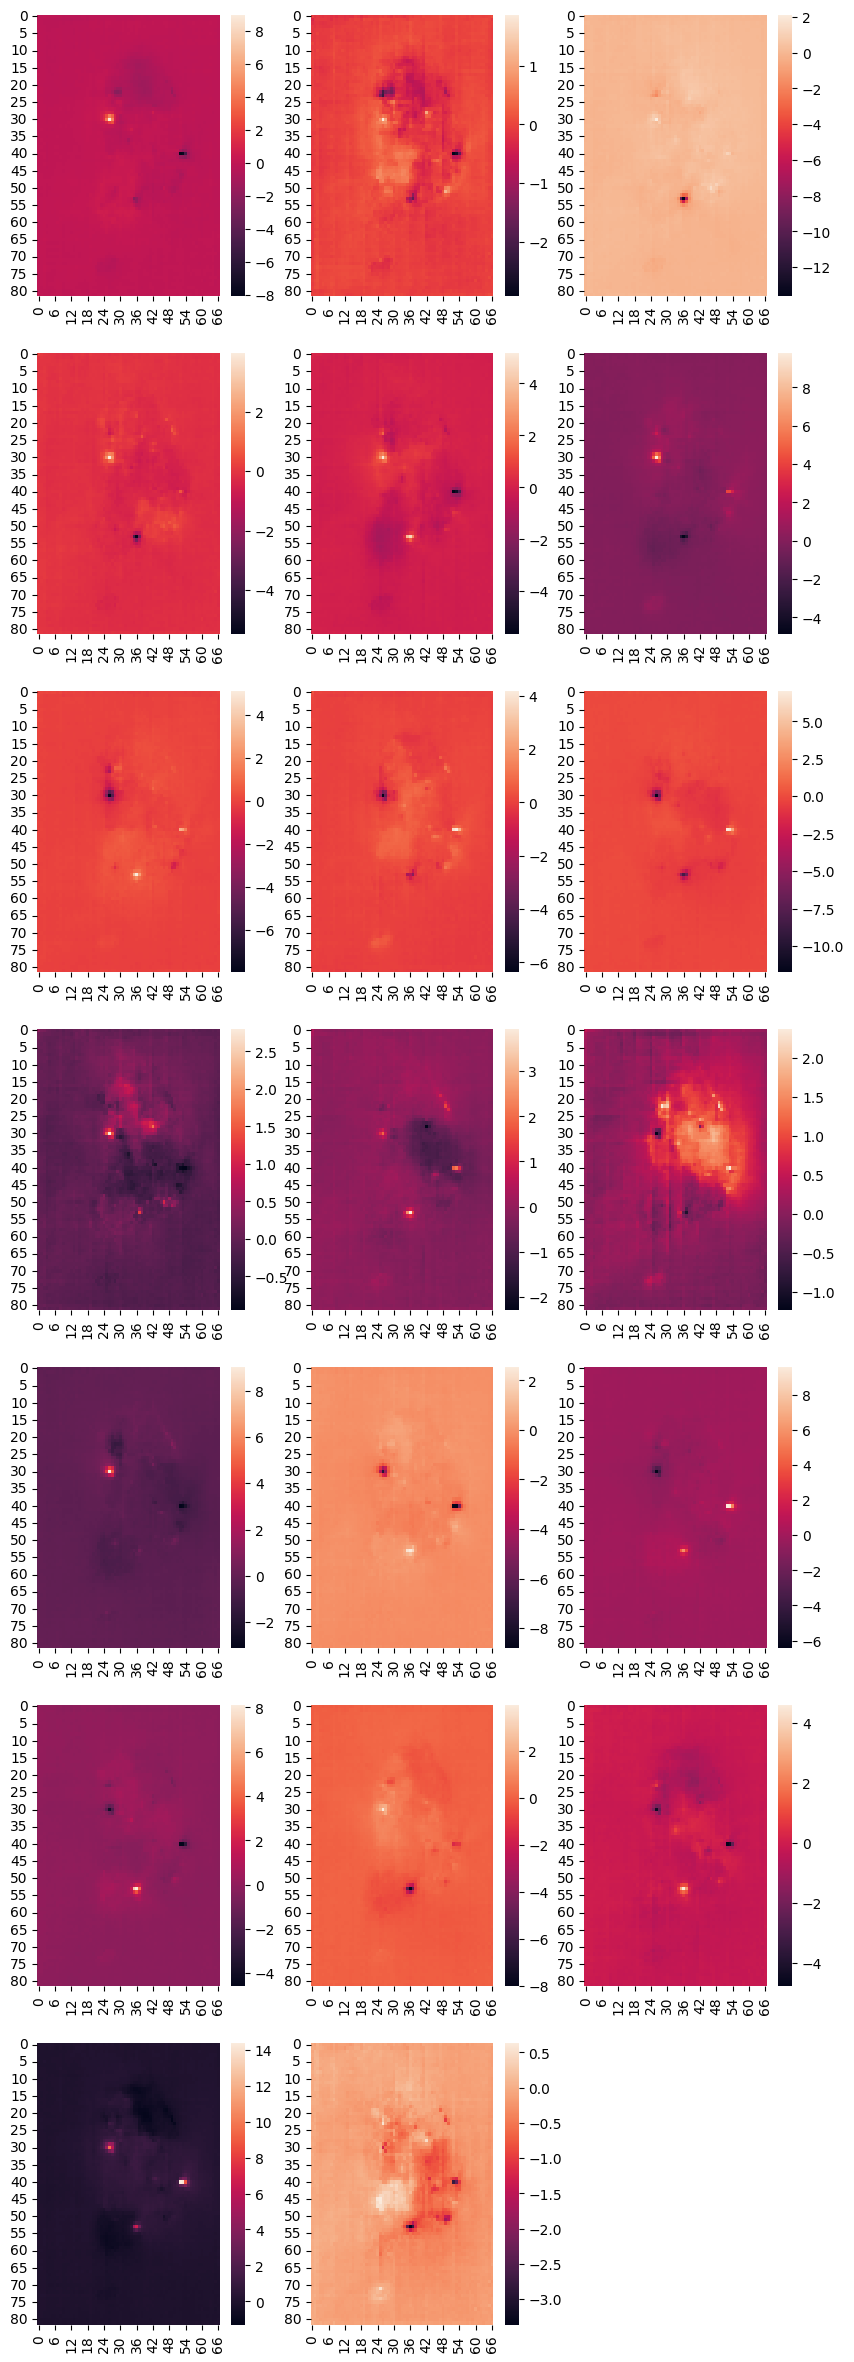

In [23]:
plt.figure(figsize = [10,30])
for i in range(len(pred_test)):
    plt.subplot(7,3,i+1)
    sns.heatmap(pred_test[i][:,:,0][::-1] - test_output[i][:,:,0][::-1])

## 모델 v3

In [10]:
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_5_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 1번 시나리오 베이스맵으로 사용
base_map = target_arr[0]
## 모델 체크포인트 생성
optimizer = tf.keras.optimizers.Adam(0.001)
unet = Unet_v5(base_map)
unet.compile()

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 unet=unet,
                                 )

# ####### 저장된 모델 있을 경우 ##########
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)

In [17]:
base_map.shape

(82, 67, 1)

* 체크

1
(1, 82, 67, 1) (1, 82, 67, 1)


2023-06-13 15:59:26.687129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [20,82,67,1]
	 [[{{node Placeholder/_2}}]]
2023-06-13 15:59:26.687843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [20,119]
	 [[{{node Placeholder/_0}}]]


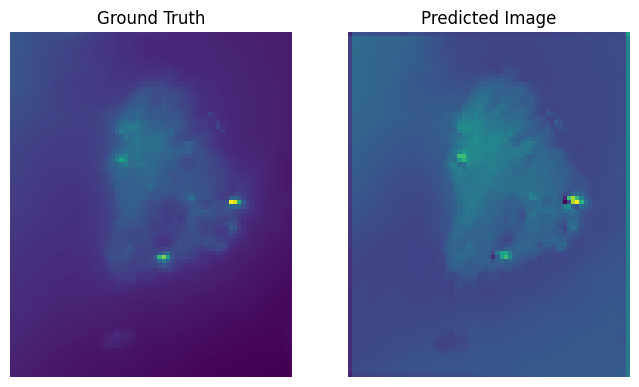

In [11]:
for batch in test_ds.take(1):
    print(1)
generate_images(unet, batch[0][0:1], batch[1][0:1])

* 학습

In [12]:
import datetime

init_lr = 0.001
steps = 2000

In [ ]:
@tf.function
def train_step(input, target,optimizer):
    with tf.GradientTape() as tape:
        output = unet(input, training=True)
        l1_loss = unet.lose_mse(target, output)
    gradients = tape.gradient(l1_loss,
                                            unet.trainable_variables)

    optimizer.apply_gradients(zip(gradients,
                                            unet.trainable_variables))
start = time.time()

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():
  
  if (step) % 100 == 0:
    if step != 0:
      print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

    start = time.time()
    print(f"Step: {step}")

  train_step(input_arr, target,optimizer)

  if step % 1000 == 0:
    if step != 0:
      init_lr = init_lr*0.1
      optimizer = tf.keras.optimizers.Adam(init_lr)
      @tf.function
      def train_step(input_image, target,optimizer):
          with tf.GradientTape() as tape:
              output = unet(input_image, training=True)
              l1_loss = unet.lose_mse(target, output)
          gradients = tape.gradient(l1_loss,
                                                  unet.trainable_variables)

          optimizer.apply_gradients(zip(gradients,
                                                  unet.trainable_variables))

  # Training step
  if (step+1) % 10 == 0:
    print('.', end='', flush=True)


  # Save (checkpoint) the model every 5k steps
  if (step + 1) % 1000 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

* 평가

5/5 [==============================] - 0s 3ms/step


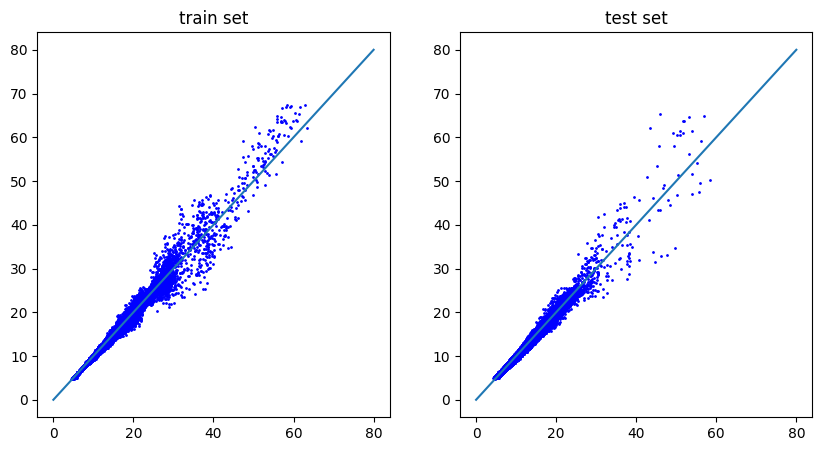

In [14]:
pred_train = unet.predict(train_input, batch_size = 4)
pred_test = unet.predict(test_input, batch_size = 4)

plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
plt.title('train set')
plt.plot(pred_train.reshape(-1), train_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

plt.subplot(1,2,2)
plt.title('test set')
plt.plot(pred_test.reshape(-1), test_output.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])

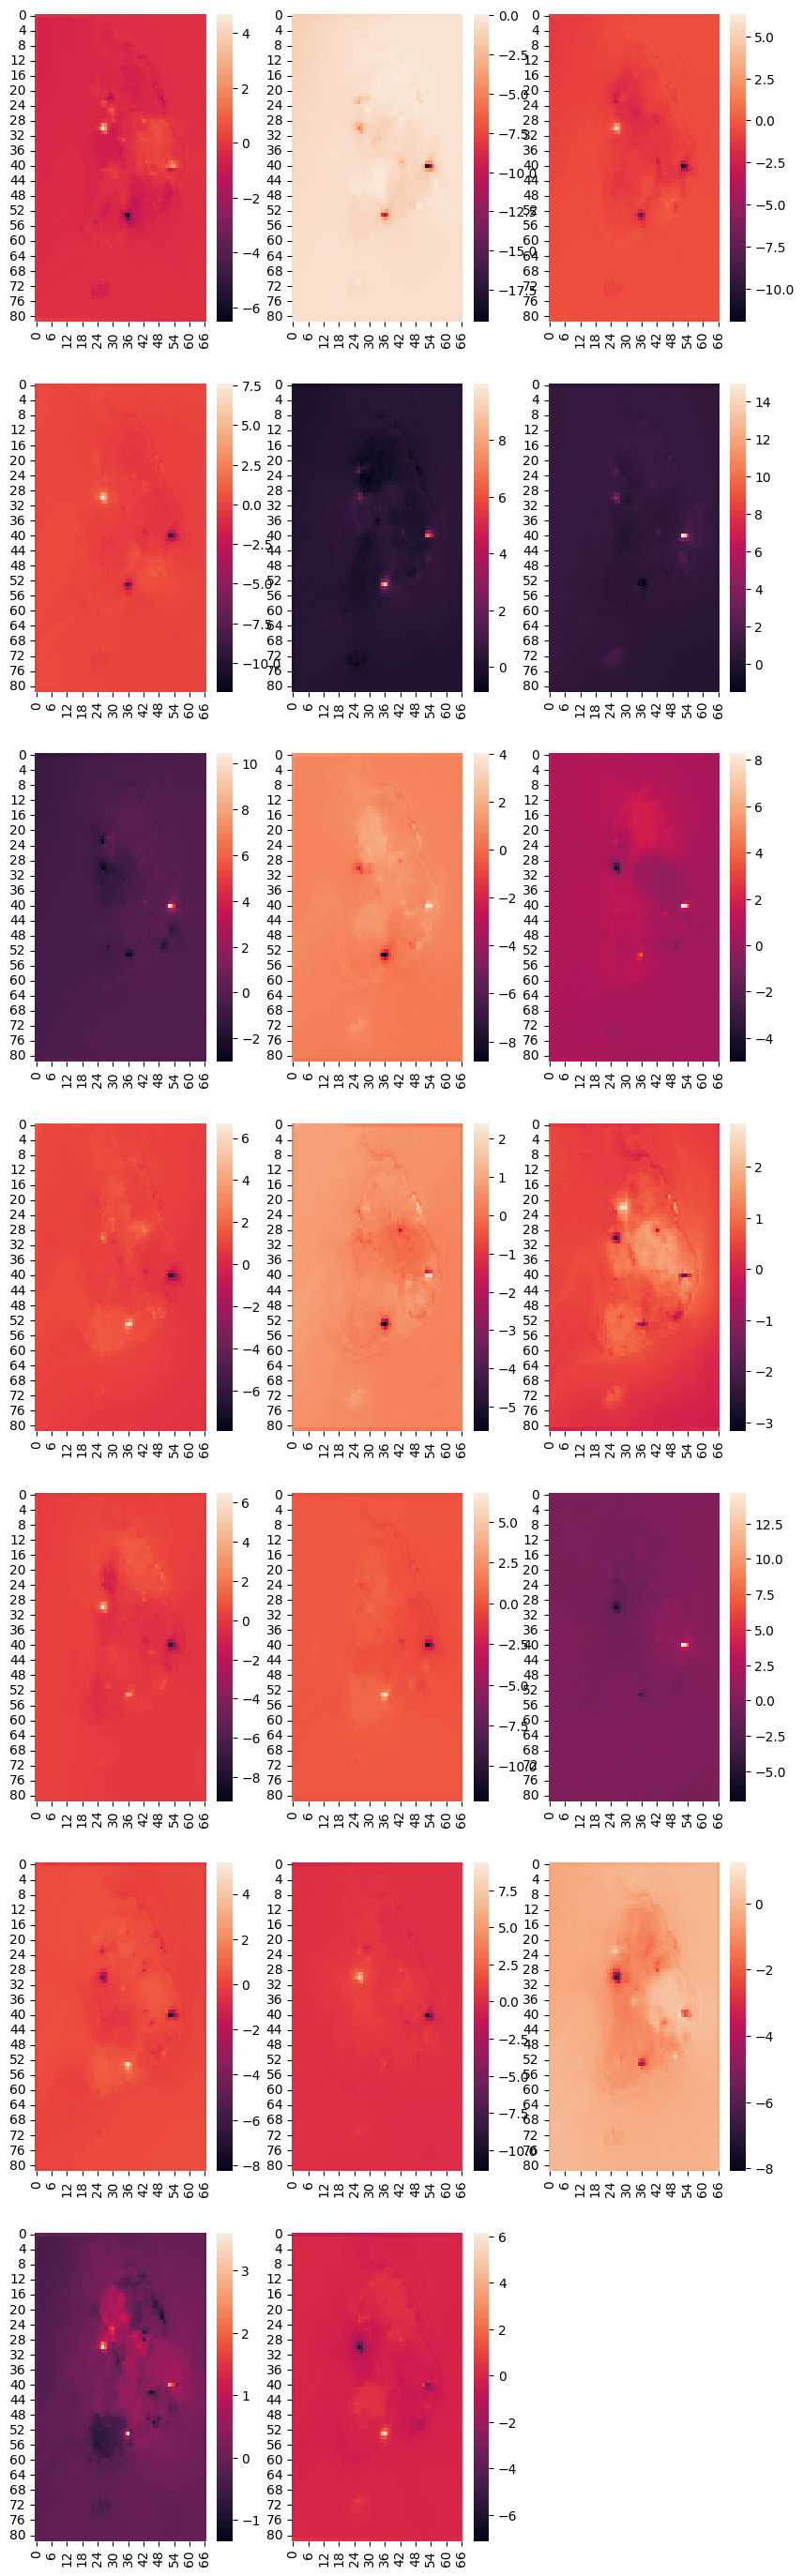

In [15]:
plt.figure(figsize = [10,35])
for i in range(len(pred_test)):
    plt.subplot(7,3,i+1)
    sns.heatmap(pred_test[i][:,:,0][::-1] - test_output[i][:,:,0][::-1])